In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [39]:
# load data
company = 'FB'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

# prepare data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [40]:
#build model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=1)) #prediction of the next cloding price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25
59/59 [==============================] - 5s 33ms/step - loss: 0.0187
Epoch 2/25
59/59 [==============================] - 2s 33ms/step - loss: 0.0038
Epoch 3/25
59/59 [==============================] - 2s 31ms/step - loss: 0.0046
Epoch 4/25
59/59 [==============================] - 2s 31ms/step - loss: 0.0035
Epoch 5/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0033
Epoch 6/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0032
Epoch 7/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0033
Epoch 8/25
59/59 [==============================] - 2s 30ms/step - loss: 0.0042
Epoch 9/25
59/59 [==============================] - 2s 38ms/step - loss: 0.0028
Epoch 10/25
59/59 [==============================] - 2s 39ms/step - loss: 0.0027
Epoch 11/25
59/59 [==============================] - 2s 38ms/step - loss: 0.0029
Epoch 12/25
59/59 [==============================] - 2s 38ms/step - loss: 0.0024
Epoch 13/25
59/59 [==================

In [41]:
'''TEST THE MODEL ON THE TEST DATA'''

#load test data
test_start=dt.datetime(2020,1,1)
test_end=dt.datetime(2020,1,31)

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values
# scale the data
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
# scale the data
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

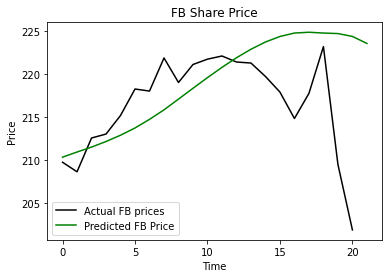

In [42]:
# make predictions on test data

x_test =[]

for x in range(prediction_days, len(model_inputs)+1):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #reshape the data

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# plot the test predictions 
plt.plot(actual_prices, color='black', label=(f'Actual {company} prices'))
plt.plot(predicted_prices, color='green', label=(f'Predicted {company} Price'))
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
# Predict the future

real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

#print(scaler.inverse_transform(real_data))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

ValueError: in user code:

    File "C:\Users\jclay\anaconda3\envs\pyviz_clone\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\jclay\anaconda3\envs\pyviz_clone\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jclay\anaconda3\envs\pyviz_clone\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\jclay\anaconda3\envs\pyviz_clone\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\jclay\anaconda3\envs\pyviz_clone\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\jclay\anaconda3\envs\pyviz_clone\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 59, 1)
